# Multivariate Anomaly Detection: Reconstruction Error Approach

This notebook demonstrates an anomaly detection system based on **Variable Reconstruction**. 

### The Concept
In a system with correlated variables, each variable can be predicted using the others as inputs. When the system behaves normally, the prediction error (residual) is low. When an anomaly occurs, the mathematical correlation "breaks," leading to a high reconstruction error.

**Mathematical Steps:**
1. **Simulation:** Create 5 correlated variables $X_1, X_2, \dots, X_5$.
2. **Modeling:** For each variable $i$, train a model $\hat{X}_i = f_i(X_{j \neq i})$.
3. **Error Calculation:** Compute the absolute residual $E_i = |X_i - \hat{X}_i|$.
4. **Risk Score:** Sum the errors and normalize them to a range of $[0, 1]$.
5. **Root Cause Analysis:** Visualize which variable contributes most to the total error.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# 1. Generate 1000 samples of 5 highly correlated variables
n_samples = 1000
latent_base = np.random.normal(0, 1, n_samples)

data = pd.DataFrame({
    'Sensor_1': latent_base + np.random.normal(0, 0.1, n_samples),
    'Sensor_2': latent_base * 0.5 + np.random.normal(0, 0.1, n_samples),
    'Sensor_3': latent_base * -0.8 + np.random.normal(0, 0.1, n_samples),
    'Sensor_4': latent_base + 0.2 + np.random.normal(0, 0.1, n_samples),
    'Sensor_5': latent_base * 1.2 + np.random.normal(0, 0.1, n_samples)
})

# 2. Inject synthetic anomalies (outliers that break the correlation)
# Point Anomaly in Sensor 1
data.loc[400:415, 'Sensor_1'] += 1.5 
# Structural Anomaly in Sensor 3
data.loc[750:765, 'Sensor_3'] -= 1

print("Dataset generated successfully. First 5 rows:")
data.head()

Dataset generated successfully. First 5 rows:


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5
0,0.636650,0.180839,-0.588152,0.610365,0.553681
1,-0.045801,-0.083584,0.024573,0.058615,-0.211259
2,0.653652,0.244602,-0.559511,0.849490,0.597662
3,1.458336,0.730719,-1.029655,1.770293,1.794627
4,-0.164331,-0.306438,0.242978,-0.170839,-0.207701


### Reconstruction Error Calculation

We treat each variable as a "target" and the remaining four as "features." We use a **Linear Regression** model to learn the dependency structure.

The residual for each variable $i$ at time $t$ is:
$$E_{i,t} = |X_{i,t} - \hat{X}_{i,t}|$$

If a sensor fails or reports false data, it will deviate from the value predicted by its peers, causing $E_i$ to spike.

In [3]:
# DataFrame to store individual reconstruction errors
errors_df = pd.DataFrame(index=data.index)

# Iterate through each column to predict it based on the others
for col in data.columns:
    X = data.drop(columns=[col])
    y = data[col]
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate absolute difference between real and predicted
    prediction = model.predict(X)
    errors_df[f'Error_{col}'] = np.abs(y - prediction)

print("Individual reconstruction errors calculated.")
errors_df.head()

Individual reconstruction errors calculated.


,Error_Sensor_1,Error_Sensor_2,Error_Sensor_3,Error_Sensor_4,Error_Sensor_5
0,0.149574,0.058818,0.210691,0.075633,0.006450
1,0.070258,0.013266,0.078462,0.009914,0.061099
2,0.063743,0.049326,0.086366,0.125253,0.148300
3,0.052167,0.024420,0.206042,0.128958,0.012823
4,0.089178,0.176200,0.032275,0.114234,0.244615


### Global Risk Score
The **Risk Score** ($RS$) aggregates all individual errors into a single health metric for the entire system. We normalize the sum using Min-Max scaling to ensure the final score is between 0 and 1:

$$RS_t = \frac{S_t - \min(S)}{\max(S) - \min(S)} \quad \text{where} \quad S_t = \sum_{i=1}^{n} E_{i,t}$$

In [4]:
# Sum all error columns
total_error_sum = errors_df.sum(axis=1).values.reshape(-1, 1)

# Normalize the sum to [0, 1]
scaler = MinMaxScaler()
data['Risk_Score'] = scaler.fit_transform(total_error_sum)

print("Risk Score calculated and added to the main DataFrame.")

Risk Score calculated and added to the main DataFrame.


### Visualizing Contributions (Root Cause Analysis)
The following chart displays the total reconstruction error over time. By **stacking** the errors of each variable, we can see exactly which sensor is responsible for driving the Risk Score higher at any given moment.

To better understand the relative impact of each variable, we normalize the error contributions. In this chart:
1. The **Y-axis** represents the range $[0, 1]$.
2. The total height of the stack at any point $t$ corresponds to the **Normalized Risk Score**.
3. The "thickness" of each colored area represents how much that specific variable is responsible for the current risk level.

This allows us to see the **percentage of responsibility** each sensor has during an anomaly.

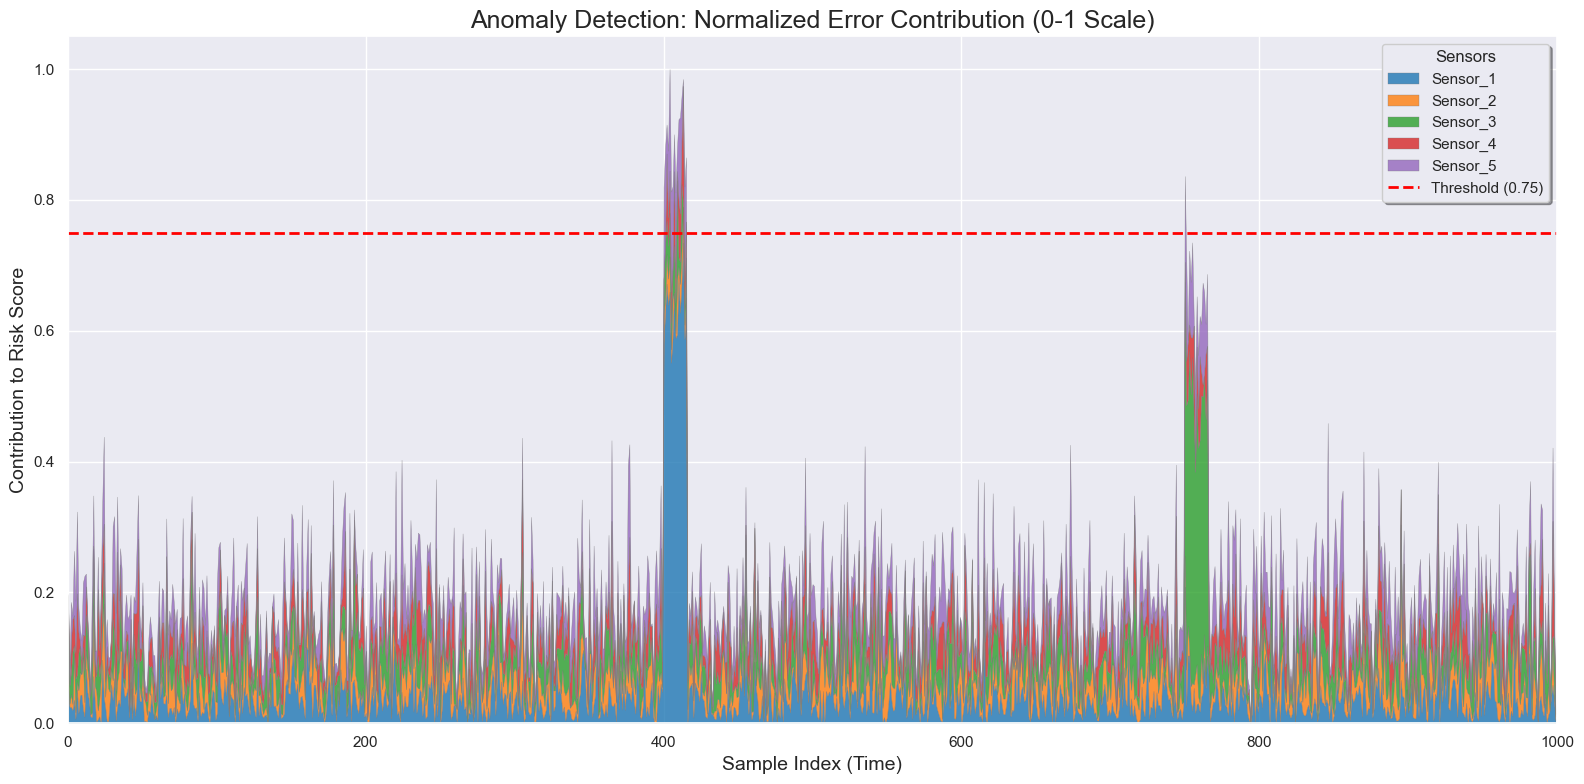

In [5]:
# 1. Calculate Proportions
# We normalize the individual error components so that their sum 
# exactly matches the value of the 'Risk_Score' column (0 to 1 scale).
total_error_sum = errors_df.sum(axis=1)

# Prevent division by zero errors for rows with zero error
total_error_sum_safe = total_error_sum.replace(0, 1e-9)

# Each column now represents its share of the normalized Risk Score
normalized_contributions = errors_df.div(total_error_sum_safe, axis=0).multiply(data['Risk_Score'], axis=0)

# 2. Set up the visualization
sns.set_theme(style="darkgrid")
plt.figure(figsize=(16, 8))

# Use a distinct color palette
colors = sns.color_palette("tab10", len(normalized_contributions.columns))

# 3. Create the Normalized Stacked Area Plot
plt.stackplot(normalized_contributions.index, 
              [normalized_contributions[col] for col in normalized_contributions.columns], 
              labels=[col.replace('Error_', '') for col in normalized_contributions.columns],
              colors=colors,
              edgecolor='gray', # Changed from white to black (or use 'none' for no lines)
              linewidth=0.3,      # Thin line for a cleaner look 
              alpha=0.8)

# 4. Overlay the Threshold line
threshold = 0.75
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')

# 5. Final Formatting and Limits
plt.title('Anomaly Detection: Normalized Error Contribution (0-1 Scale)', fontsize=18)
plt.xlabel('Sample Index (Time)', fontsize=14)
plt.ylabel('Contribution to Risk Score', fontsize=14)
plt.ylim(0, 1.05)  # Set Y-axis to 0-1 (with a little headroom)
plt.xlim(0, n_samples)

# Move legend outside to keep the plot clean
plt.legend(loc='upper right', title="Sensors", frameon=True, shadow=True)

plt.tight_layout()
plt.show()

### Anomaly Detection Reporting
In this section, we define a critical threshold for the **Risk Score** (e.g., $0.75$). The script automatically identifies the time periods where the system deviates from normal behavior and extracts the variable that had the highest contribution to the error at that moment (**Root Cause**).

This allows us to move from just "seeing" a problem to "diagnosing" exactly which sensor is failing.

--- ANOMALIES DETECTED: 17 points ---
     Risk_Score Root_Cause
400    0.819479   Sensor_1
401    0.880248   Sensor_1
402    0.915104   Sensor_1
403    0.875256   Sensor_1
404    1.000000   Sensor_1
405    0.812939   Sensor_1
406    0.820545   Sensor_1
407    0.900346   Sensor_1
408    0.811311   Sensor_1
409    0.879557   Sensor_1
410    0.923209   Sensor_1
411    0.926165   Sensor_1
412    0.956956   Sensor_1
413    0.984747   Sensor_1
414    0.820461   Sensor_1

--- Summary of Root Causes ---
Root_Cause
Sensor_1    16
Sensor_3     1
Name: count, dtype: int64


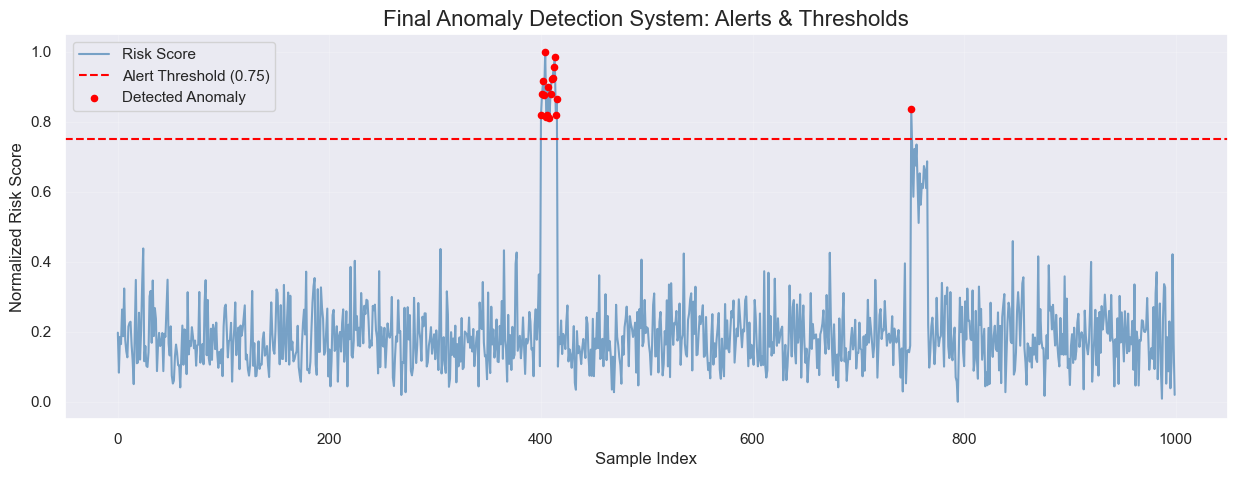

In [6]:
# 1. Define the detection threshold
# Any score above this will be flagged as a critical anomaly
threshold = 0.75

# 2. Filter the moments where the Risk Score exceeds the threshold
anomalies = data[data['Risk_Score'] > threshold].copy()

if not anomalies.empty:
    # 3. Identify the Root Cause for each anomaly
    # We look into errors_df to see which reconstruction error was the highest at that specific timestamp
    # We strip the 'Error_' prefix for a cleaner report
    relevant_errors = errors_df.loc[anomalies.index]
    anomalies['Root_Cause'] = relevant_errors.idxmax(axis=1).apply(lambda x: x.replace('Error_', ''))
    
    print(f"--- ANOMALIES DETECTED: {len(anomalies)} points ---")
    print(anomalies[['Risk_Score', 'Root_Cause']].head(15))
    
    # 4. Summarize findings
    print("\n--- Summary of Root Causes ---")
    print(anomalies['Root_Cause'].value_counts())
else:
    print("No anomalies detected above the defined threshold.")

# 5. Visual Validation
plt.figure(figsize=(15, 5))
plt.plot(data['Risk_Score'], label='Risk Score', color='steelblue', alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Alert Threshold ({threshold})')

# Highlight detected points in red
plt.scatter(anomalies.index, anomalies['Risk_Score'], color='red', s=20, label='Detected Anomaly', zorder=5)

plt.title('Final Anomaly Detection System: Alerts & Thresholds', fontsize=16)
plt.xlabel('Sample Index')
plt.ylabel('Normalized Risk Score')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)
plt.show()

### Implementing Alarm Suppression (On-Delay / Off-Delay)

Raw anomalies are often noisy. To create a robust industrial alarm, we implement:
1. **On-Delay:** The system must remain in an anomalous state ($Risk\_Score > Threshold$) for $N$ consecutive samples before the alarm is triggered.
2. **Off-Delay:** Once the alarm is active, the system must remain in a normal state for $M$ consecutive samples before the alarm is cleared.

This prevents "flickering" alarms caused by minor signal noise.

In [7]:
# 1. Configuration
on_delay_samples = 5   # System must be 'bad' for 5 samples to trigger alarm
off_delay_samples = 3  # System must be 'good' for 3 samples to clear alarm
threshold = 0.75

# 2. Initialization
raw_anomaly = data['Risk_Score'] > threshold
alarm_status = np.zeros(len(data), dtype=bool)
current_state = False  # False = No Alarm, True = Alarm Active
counter = 0

# 3. State Machine Loop
for i in range(len(data)):
    is_above_threshold = raw_anomaly.iloc[i]
    
    if not current_state:
        # Looking to trigger the alarm
        if is_above_threshold:
            counter += 1
            if counter >= on_delay_samples:
                current_state = True
                counter = 0
        else:
            counter = 0
    else:
        # Looking to clear the alarm
        if not is_above_threshold:
            counter += 1
            if counter >= off_delay_samples:
                current_state = False
                counter = 0
        else:
            counter = 0
            
    alarm_status[i] = current_state

data['Alarm_Active'] = alarm_status
print(f"Alarm logic processed. Total alarm samples: {data['Alarm_Active'].sum()}")

Alarm logic processed. Total alarm samples: 14


### Visualizing the Filtered Alarm
The plot below compares the **Raw Anomaly Detection** (instantaneous) against the **Filtered Alarm** (after On/Off delays). You will notice that short spikes no longer trigger the alarm, and the alarm stays "latched" for a few samples even after the signal drops below the threshold.

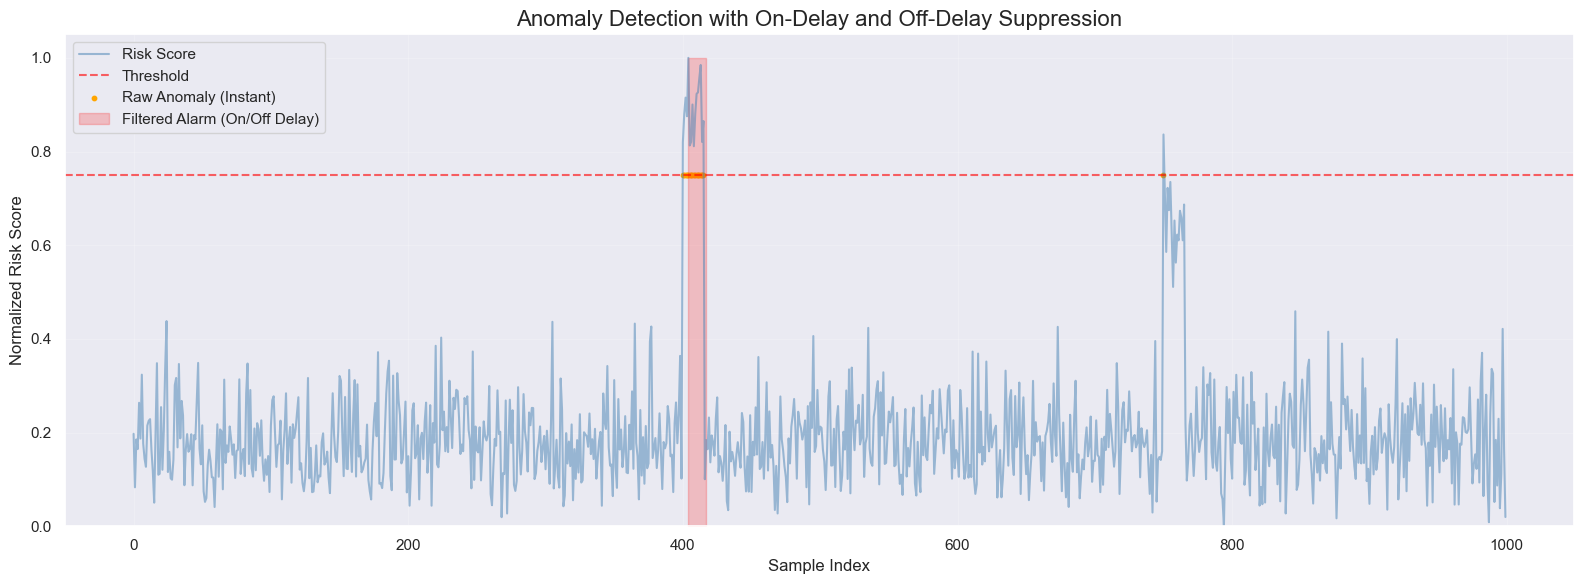

In [8]:
plt.figure(figsize=(16, 6))

# Plot Risk Score
plt.plot(data.index, data['Risk_Score'], color='steelblue', alpha=0.5, label='Risk Score')
plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.6, label='Threshold')

# Plot Raw Detections (as small dots)
plt.scatter(data.index[raw_anomaly], [threshold]*raw_anomaly.sum(), 
            color='orange', s=10, label='Raw Anomaly (Instant)')

# Plot Filtered Alarms (as a shaded area)
plt.fill_between(data.index, 0, 1, where=data['Alarm_Active'], 
                 color='red', alpha=0.2, label='Filtered Alarm (On/Off Delay)')

plt.title('Anomaly Detection with On-Delay and Off-Delay Suppression', fontsize=16)
plt.xlabel('Sample Index')
plt.ylabel('Normalized Risk Score')
plt.ylim(0, 1.05)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### Alarm Event Summary Report
While the visual plot is helpful, operational teams need a specific list of events. The following code identifies contiguous blocks where the alarm was active, recording the **Start Index**, **End Index**, and the **Total Duration** of the anomaly event.

In [9]:
# 1. Detect state changes in the Filtered Alarm
# A change from 0 to 1 is a Start, 1 to 0 is an End
alarm_diff = data['Alarm_Active'].astype(int).diff()

starts = data.index[alarm_diff == 1].tolist()
ends = data.index[alarm_diff == -1].tolist()

# Handle case where alarm is active until the very last sample
if data['Alarm_Active'].iloc[-1]:
    ends.append(data.index[-1])

# 2. Create the Summary Table
event_list = []
for start, end in zip(starts, ends):
    duration = end - start
    
    # Identify the most frequent root cause during this specific alarm window
    event_errors = errors_df.loc[start:end]
    primary_cause = event_errors.idxmax(axis=1).mode()[0].replace('Error_', '')
    
    # Calculate peak Risk Score during the event
    peak_score = data.loc[start:end, 'Risk_Score'].max()
    
    event_list.append({
        'Event_ID': len(event_list) + 1,
        'Start_Index': start,
        'End_Index': end,
        'Duration_Samples': duration,
        'Peak_Risk': round(peak_score, 4),
        'Primary_Cause': primary_cause
    })

event_summary = pd.DataFrame(event_list)

# 3. Display the Table
if not event_summary.empty:
    print("--- ALARM EVENT LOG ---")
    display(event_summary) # Using display() for nice formatting in Jupyter
else:
    print("No confirmed alarm events recorded.")

--- ALARM EVENT LOG ---


,Event_ID,Start_Index,End_Index,Duration_Samples,Peak_Risk,Primary_Cause
0,1,404,418,14,1.0,Sensor_1
